# Initialization



In [16]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

!pip install tensorboardx

from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append("/content/gdrive/My Drive/Colab Notebooks/DeepWololo/python_files")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
drive.mount("/content/gdrive", force_remount=True)
#sys.path.append("/content/gdrive/My Drive/Colab Notebooks/DeepWololo/python_files")

Mounted at /content/gdrive


In [18]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2018-10-27 13:13:16--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.1.117.85, 52.20.145.121, 35.173.3.255, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.1.117.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  19.3MB/s    in 0.3s    

2018-10-27 13:13:16 (19.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

In [80]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://7d1bbe92.ngrok.io


In [21]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

from model_trainer import ModelTrainer
from utils import *
from data_loader import *
from nn_models import *
import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
torch.__version__

'0.4.1'

In [23]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False, full=True)
train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
Processing...
Done!
** Use 60000 train and 10000 test samples


In [0]:
train_input = train_input.narrow(0, 0, 10000)
train_target = train_target.narrow(0, 0, 10000)

5


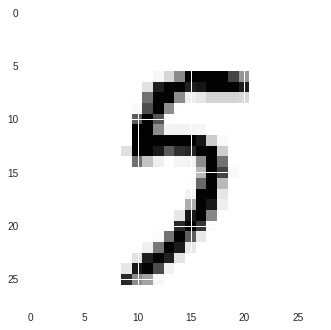

In [25]:
i = 420
plt.imshow(train_input[i, 0, :, :])
print(train_target[i].item())

## 1) LeNet F

In [0]:
def shadow_model(vector_dimension) :
  channels = vector_dimension[1]
  size = vector_dimension[2]
  linear_size = ((((size - 2) // 2) - 2) // 2) ** 2 * 64 
  
  model = nn.Sequential(
      nn.Conv2d(channels, 32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(32 ,32, kernel_size=3),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Dropout(0.25),
      
      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(64 ,64, kernel_size=3),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Dropout(0.25),
      
      View([-1]),
      nn.Linear(linear_size, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, 10)
  )
  return model

In [0]:
#debug_layers_dims(shadow_model(vector_dimension), vector_dimension)

In [0]:
train_dataset = (train_input.narrow(0, 0, 5000), train_target.narrow(0, 0, 5000))
test_dataset = (test_input.narrow(0, 0, 5000), test_target.narrow(0, 0, 5000))

in_channels = train_input.shape[1]
out_channels = 10

In [0]:
#debug_layers_dims(LeNet(), train_input.shape)

In [30]:
target_classes = np.array(train_dataset[1].tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

{0: 479, 1: 563, 2: 488, 3: 493, 4: 535, 5: 434, 6: 501, 7: 550, 8: 462, 9: 495}


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.00368373           0.391      0.00021109           0.666
10                   0.00046222           0.930      0.00004897           0.921
20                   0.00030494           0.950      0.00003412           0.943
30                   0.00022825           0.963      0.00002827           0.952
39                   0.00018535           0.972      0.00002580           0.956
*******************************************************************************


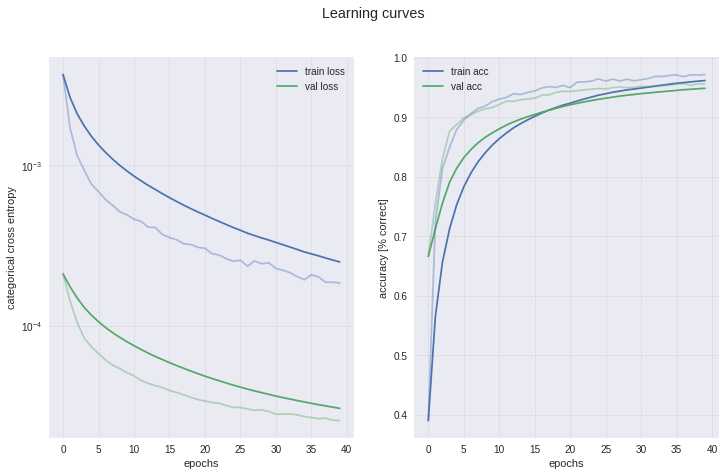

In [32]:
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
batch_cap = 40
batch_fun = lambda x, y: x * (y // batch_cap + 1)
vector_dimension = train_dataset[0].shape

net = shadow_model(vector_dimension)
loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.001

batch_size = 500

dataset = 'MNIST'
tsx_name = LOG_DIR + '/{}_lr_{},batchSize_{}'.format(dataset, learning_rate, batch_size)

mt = ModelTrainer(net, loss_fun, optim.Adagrad(net.parameters(), lr=learning_rate), y_hat_fun, crit_fun, batch_fun, tsx_name)
hist = mt.fit(train_dataset, test_dataset, epochs=40, batch_size=batch_size, verbose=10)
mt.plot_training("Learning curves")

##1.2) 10F


training shadow model [0] ...done !
training shadow model [1] ...done !
training shadow model [2] ...done !
training shadow model [3] ...done !
training shadow model [4] ...done !
training shadow model [5] ...done !
training shadow model [6] ...done !
training shadow model [7] ...done !
training shadow model [8] ...done !
training shadow model [9] ...done !


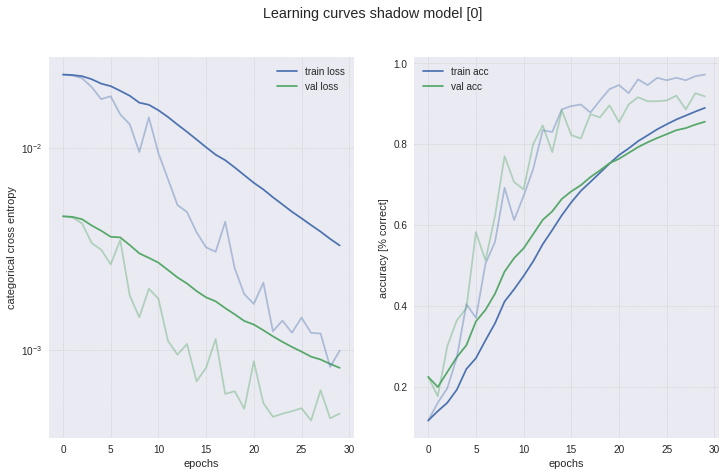

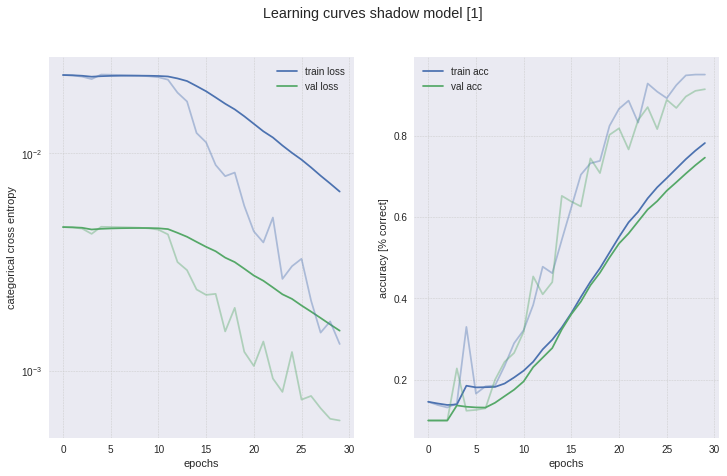

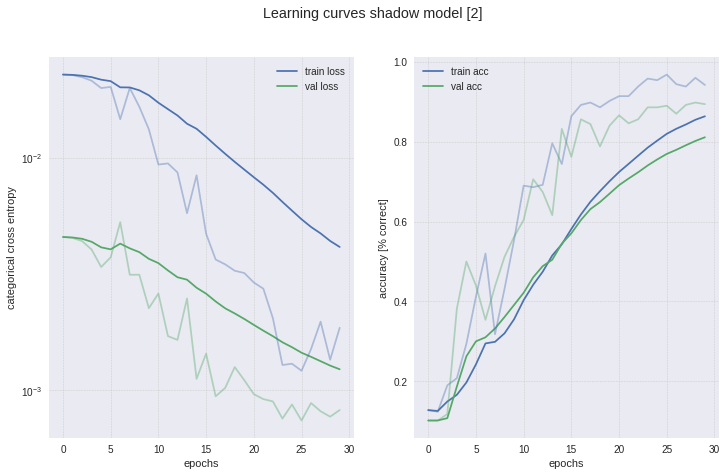

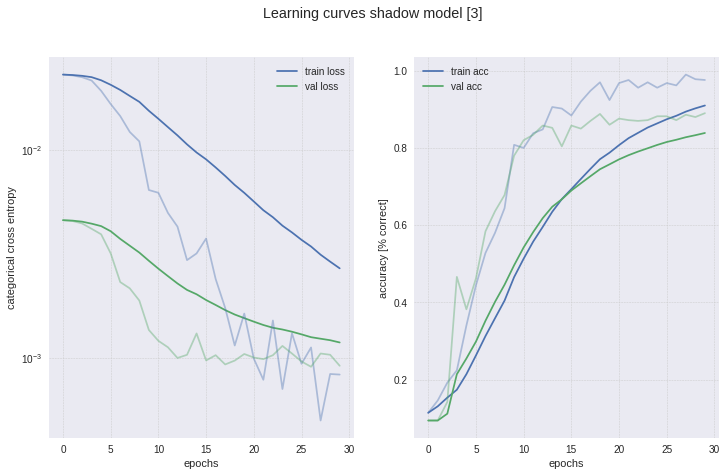

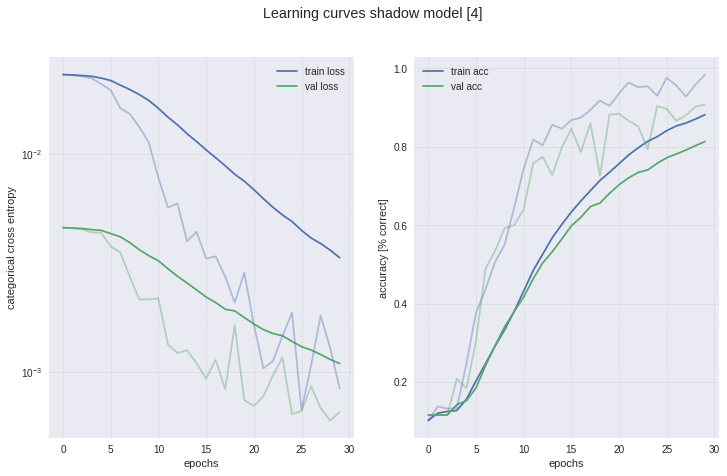

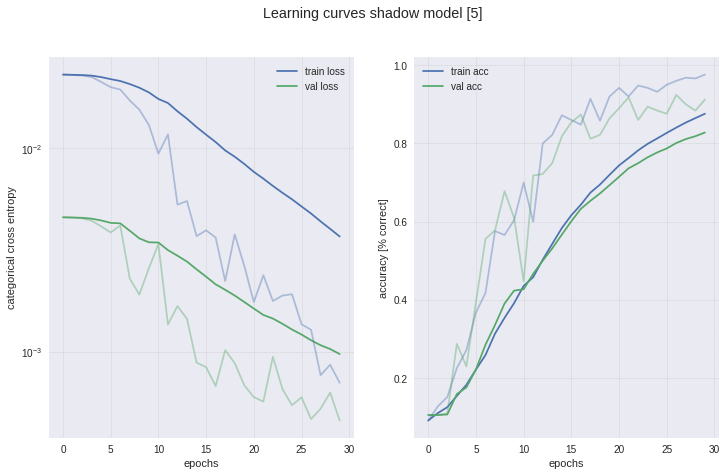

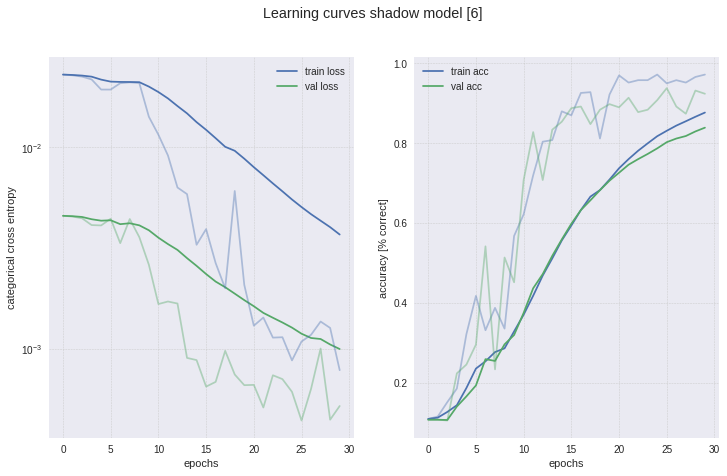

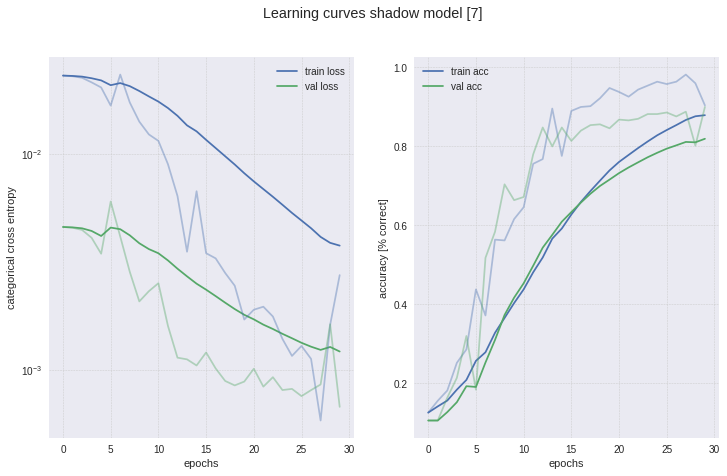

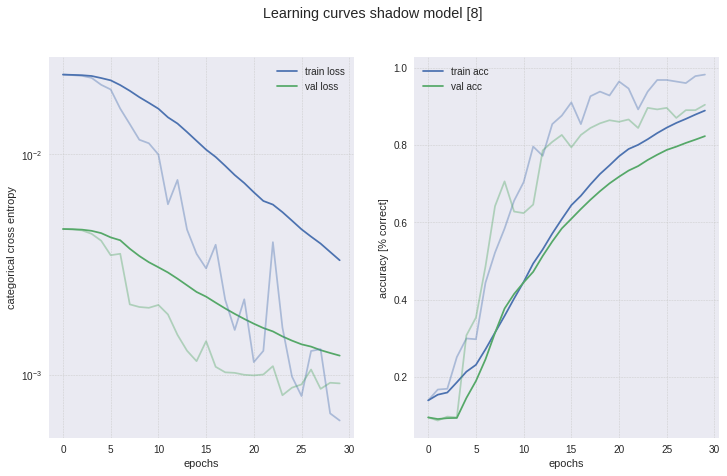

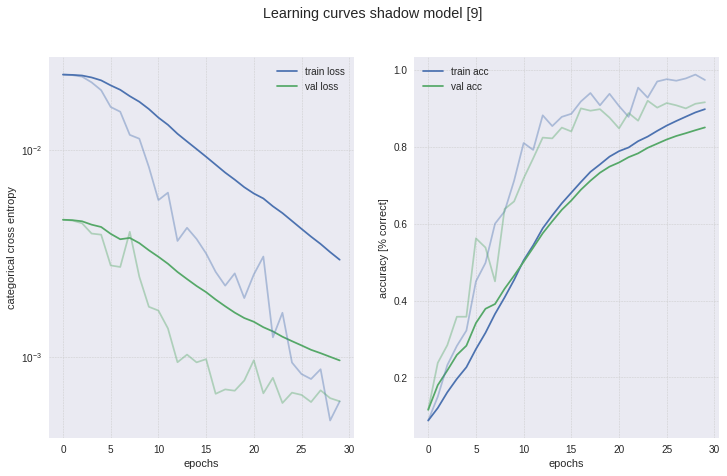

In [35]:
(shadow_train_datasets, shadow_test_datasets) = generate_n_shadow_models_datasets(10, train_dataset, test_dataset)

#Define training parameters
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
learning_rate = 0.1
nb_epochs = 30
batch_size = 100
verbose = 0

#create the shadow models
model_class = shadow_model
shadow_models = list()
for i in range(10):
    shadow_models.append(model_class(vector_dimension))
    
#train the shadow models
for i in range(10):
    print("training shadow model ["+str(i)+"] ...", end='')
    tsx_name = LOG_DIR + '/{}/F/shadow[{}]_lr_{},batchSize_{}'.format(dataset, i, learning_rate, batch_size)

    crossEntropyClassesWeigths = computeClassesWeights(shadow_train_datasets[i][1])

    loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)

    mt = ModelTrainer(shadow_models[i], loss_fun, optim.SGD(shadow_models[i].parameters(), lr=learning_rate), y_hat_fun, crit_fun, tsx_name = tsx_name)
    hist = mt.fit(shadow_train_datasets[i], shadow_test_datasets[i], epochs=nb_epochs, batch_size=batch_size, verbose=verbose)
    mt.plot_training("Learning curves shadow model ["+str(i)+"]")
    print("done !")


## 2) Net G

## Net def

In [109]:
32 * 6 * 6

1152

In [0]:
def kindaResnetG(layer_dim):
  dim = layer_dim[2]
  pad = (1, 1, 1)
  pool = 2
  finalVectorSize = (layer_dim[2]//pool) * (layer_dim[3]//pool) * (layer_dim[4]//pool)
  model = nn.Sequential(
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.MaxPool3d(pool),
      
      View([-1]),
      nn.Linear(finalVectorSize, 512),
      nn.ELU(),
      nn.Dropout3d(),
      #nn.Linear(64, 128),
      #nn.ReLU(),
      nn.Linear(512, 128),
      nn.ELU(),
      nn.Dropout3d(),
      nn.Linear(128, 128),
      nn.ELU(),
      nn.Dropout3d(0.8),
      nn.Linear(128, 2),
      
  )
  return model

def ResnetG(layer_dim): # ba:50 ,bs:100
  dim = layer_dim[2]
  pad = (1, 1, 1)
  pool = 2
  finalVectorSize = (layer_dim[2]//pool) * (layer_dim[3]//pool) * (layer_dim[4]//pool)
  model = nn.Sequential(
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.MaxPool3d(pool),
      
      View([-1]),
      nn.Linear(finalVectorSize, 64),
      nn.ELU(),
      nn.Linear(64, 128),
      nn.ELU(),
      nn.Linear(128, 128),
      nn.ELU(),
      nn.Linear(128, 2),
      
  )
  return model

def aliGs(vector_size):
    finalVectorSize = (((((vector_size-7)//2)-4)//2)-2)//2
    
    model = nn.Sequential(
        nn.Conv1d(1, 32, kernel_size = 8),
        nn.RReLU(),
        nn.BatchNorm1d(32),
        nn.MaxPool1d(kernel_size = 2),
        
        nn.Conv1d(32, 64, kernel_size = 5),
        nn.RReLU(),
        nn.BatchNorm1d(64),
        nn.MaxPool1d(kernel_size = 2),
        
        nn.Conv1d(64, 16, kernel_size = 3),
        nn.RReLU(),
        nn.BatchNorm1d(16),
        nn.MaxPool1d(kernel_size = 2),
        
        View([-1]),
        nn.Linear(16* finalVectorSize, 100),
        nn.RReLU(),
        nn.Dropout(),
        
        nn.Linear(100, 32),
        nn.RReLU(),
        nn.Dropout(),
        
        nn.Linear(32, 2)
    )
    
    return model
  
def daAliG(vector_size):
    finalVectorSize = (((((vector_size-7)//2)-4)//2)-2)//2
    
    model = nn.Sequential(
        nn.Conv1d(1, 256, kernel_size = 8, stride=1),
        nn.RReLU(),
        nn.BatchNorm1d(256),
        nn.MaxPool1d(kernel_size = 2),
        
        nn.Conv1d(256, 128, kernel_size = 5),
        nn.RReLU(),
        nn.BatchNorm1d(128),
        nn.MaxPool1d(kernel_size = 2),
        
        nn.Conv1d(128, 16, kernel_size = 3),
        nn.RReLU(),
        nn.BatchNorm1d(16),
        nn.MaxPool1d(kernel_size = 2),
        
        View([-1]),
        nn.Linear(16* finalVectorSize, 128),
        nn.RReLU(),
        nn.Dropout(),
        
        nn.Linear(128, 128),
        nn.RReLU(),
        nn.Dropout(),
        
        nn.Linear(128, 32),
        nn.RReLU(),
        nn.Dropout(),
        
        nn.Linear(32, 2)
    )
    
    return model
  
def denseG(vector_size):
    model = nn.Sequential(
        View([-1]),
        nn.Linear(vector_size, 128),
        nn.RReLU(),
        nn.Dropout(0.3),
        
        nn.Linear(128, 128),
        nn.RReLU(),
        nn.Dropout(0.2),
        
        nn.Linear(128, 2),
    )
    return model

In [82]:
debug_layers_dims(Gshadow(g_train_dataset[0].shape), g_train_dataset[0].shape)

******************** Debugging layers sizes: ********************
input_shape= (_,1,64,11,11)
------------------
View(_, [-1])
(_,1,64,11,11) --> (_,7744)
------------------
Linear(in_features=7744, out_features=512, bias=True)
(_,7744) --> (_,512)
------------------
ReLU()
(_,512) --> (_,512)
------------------
Dropout(p=0.5)
(_,512) --> (_,512)
------------------
Linear(in_features=512, out_features=2, bias=True)
(_,512) --> (_,2)
*****************************************************************


tensor([[-0.4502, -0.0494],
        [ 0.1847,  0.1419]], grad_fn=<ThAddmmBackward>)

## Playground n=1

In [0]:
label = 5
idx = train_dataset[1] == label
label_train_dataset = (train_dataset[0][idx], train_dataset[1][idx])
idx = test_dataset[1] == label
label_test_dataset = (test_dataset[0][idx], test_dataset[1][idx])

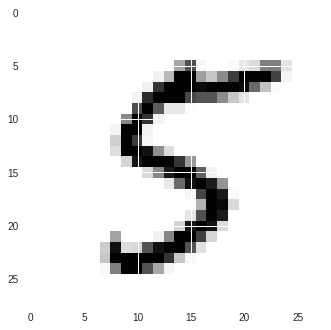

In [14]:
i = 10
plt.imshow(label_test_dataset[0][i, 0, :, :])

In [42]:
net0 = shadow_models[0]
net0

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.25)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.25)
  (12): View(_, [-1])
  (13): Linear(in_features=1024, out_features=512, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5)
  (16): Linear(in_features=512, out_features=10, bias=True)
)

In [0]:
(g_train_input, g_train_target), (g_test_input, g_test_target) = \
generate_dataset_g(net, train_dataset, test_dataset, [net[8]], ['conv'], split=0.8, full=True)

g_train_target = g_train_target.long()
g_test_target = g_test_target.long()

g_train_dataset = (g_train_input, g_train_target)
g_test_dataset = (g_test_input, g_test_target)  

In [100]:
g_train_input.shape

torch.Size([8000, 1, 64, 13, 13])

In [101]:
size_input_vector = g_train_dataset[0].shape#[2]
print("size of layer vector :", size_input_vector)

size of layer vector : torch.Size([8000, 1, 64, 13, 13])


In [102]:
g_train_dataset[1].shape[0]

8000

In [103]:
target_classes = np.array(g_train_dataset[1].tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

{0: 4000, 1: 4000}


In [114]:
modelG = kindaResnetG(size_input_vector)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
batch_cap = 40
batch_fun = lambda x, y: x // (y // batch_cap + 1) #x: batch_size, y: epoch

loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.01

mt = ModelTrainer(modelG, loss_fun, optim.Adagrad(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun, batch_fun)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=100, batch_size=2000, verbose=10)
mt.plot_training("Learning curves for G analysis model")

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.00086375           0.491      0.00038647           0.500
10                   0.00034675           0.519      0.00034668           0.504
20                   0.00034287           0.548      0.00034754           0.516
30                   0.00033972           0.566      0.00035122           0.520
40                   0.00067090           0.585      0.00035283           0.515
50                   0.00066165           0.602      0.00035828           0.503


KeyboardInterrupt: ignored

## Playground n = 10

In [0]:
def Gshadow(vector_dimension) :
  channels = vector_dimension[1]
  size = vector_dimension[2]
  linear_size = 7744#(((((size - 2) // 2) - 2) // 2) ** 2) * 64 
  
  model = nn.Sequential(
      View([-1]),
      nn.Linear(linear_size, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, 2)
  )
  return model

In [0]:
def generate_dataset_g_per_class_from_shadows(models, train_dataset, test_dataset, layers, layer_names, split=0.7, full=True):
    """
    Generate the dataset for g with the values spied from the given layers for each models as input and the
    labels taking value '1' if the original data was part of the train set, '0' otherwise. 
    The generated datasets are separated by classes, ie. if your original training/testing
    data had n target classes, this function will return two lists (train and test) of n 
    components, with the i-th component being the train or test dataset for the i-th 
    target class.
    Args:
    -models : Array containing the models to spy
    -train_dataset: original train dataset
    -test_dataset: original test dataset
    -layers: Array of array containing the model layers to spy on
    -layer_name: Array of array containing the names of the layer, to be used as keys in the returned
    -split: Percentage of data to keep for the new train dataset
    Returns:
    -list of n new train datasets
    -list of n new test dataset
    """
    train_input, train_target = train_dataset
    test_input, test_target = test_dataset
    
    target_classes = torch.unique(train_target, sorted=True)

    train_mask_classes = [train_target == c for c in target_classes]
    test_mask_classes = [test_target == c for c in target_classes]

    train_dataset_classes = [(train_input[mask], train_target[mask]) for mask in train_mask_classes]
    test_dataset_classes = [(test_input[mask], test_target[mask]) for mask in test_mask_classes]
    
    g_train_dataset_classes = list()
    g_test_dataset_classes = list()

    for c in target_classes:
        g_train_input_full = None
        g_train_target_full = None
        g_test_input_full = None
        g_test_target_full = None

        for i, net in enumerate(models):
            (g_train_input, g_train_target), (g_test_input, g_test_target) = \
            generate_dataset_g(net, train_dataset_classes[c], test_dataset_classes[c], layers[i], layer_names[i], split=split, full=full)

            g_train_target = g_train_target.long()
            g_test_target = g_test_target.long()

            if g_train_input_full is None:
                g_train_input_full = g_train_input
                g_train_target_full = g_train_target
                g_test_input_full = g_test_input
                g_test_target_full = g_test_target
            else:
                g_train_input_full = torch.cat((g_train_input_full,g_train_input), 0)
                g_train_target_full = torch.cat((g_train_target_full, g_train_target), 0)
                g_test_input_full = torch.cat((g_test_input_full, g_test_input), 0)
                g_test_target_full = torch.cat((g_test_target_full, g_test_target), 0)

        (tmp1, tmp2) = (g_train_input_full, g_train_target_full), (g_test_input_full, g_test_target_full)
            
        g_train_dataset_classes.append(tmp1)
        g_test_dataset_classes.append(tmp2)
        
    return g_train_dataset_classes, g_test_dataset_classes




In [0]:
layers = [[l[8]] for l in shadow_models]
layer_names = [['conv'] for l in shadow_models]
g_train_dataset_classes, g_test_dataset_classes = generate_dataset_g_per_class_from_shadows(shadow_models, train_dataset, test_dataset, layers, layer_names, split=0.7, full=True)

*************** Class 6 ********************
size of layer vector : torch.Size([6730, 1, 64, 11, 11])
repartition of labels : {0: 3230, 1: 3500}
******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.00721969           0.530      0.00023647           0.542
10                   0.00620816           0.651      0.00024673           0.537
20                   0.00608776           0.659      0.00024435           0.568
30                   0.00596651           0.673      0.00024674           0.566
40                   0.00591634           0.675      0.00024770           0.567
50                   0.00290593           0.677      0.00024761           0.574
60                   0.00291809           0.685      0.00024823           0.573
70                   0.00288958           0.691      0.00024744           0.577
80                   0.00287582           0.687      0.

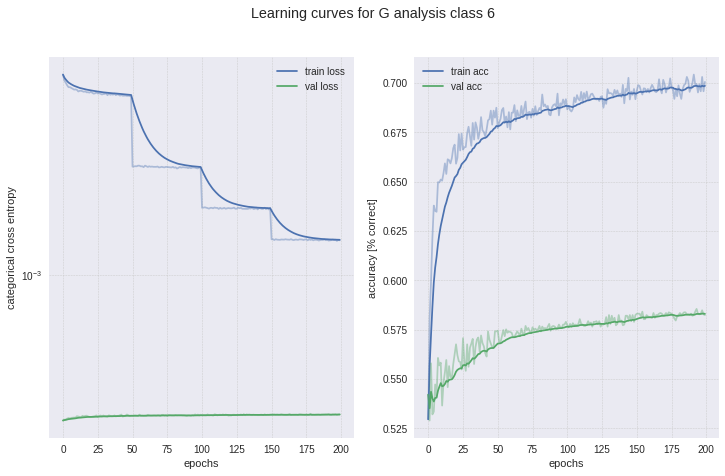

In [84]:
#for i in range(10):
i=6
g_train_dataset = g_train_dataset_classes[i]
g_test_dataset = g_test_dataset_classes[i]

size_input_vector = g_train_dataset[0].shape#[2]
print('*************** Class {} ********************'.format(i))
print("size of layer vector :", size_input_vector)

target_classes = np.array(g_train_dataset[1].tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print("repartition of labels :", dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

modelG = kindaResnetG(size_input_vector)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
batch_cap = 50
batch_fun = lambda x, y: x * (y // batch_cap + 1) #x: batch_size, y: epoch

loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.001
batch_size = 100
tsx_name = LOG_DIR + '/{}/G/kindaResnetG[{}]_lr_{},batchSize_{},batchCap_{}'.format(dataset, i, learning_rate, batch_size, batch_cap)

mt = ModelTrainer(modelG, loss_fun, optim.Adagrad(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun, batch_fun, tsx_name, nb_labels=2)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=200, batch_size=batch_size, verbose=10)
mt.plot_training("Learning curves for G analysis class {}".format(i))